In [1]:
# %pip install seqlogo
import pandas as pd
import numpy as np
from collections import namedtuple

In [18]:
df = pd.read_pickle("/home/hb/python/phospho/data/required/0308_final_train_test/dataset3.pkl")
df_mapk = df[df['Family']=='MAPK'].reset_index(drop=True)
df_mapk

,pair11,Name,Family,Group,kin_id,subseq,sub_id,answer,pair,subseq13,kinseq,matrix,repl,type
0,O15264_Q92993_VVSPATPVPSE,p38d,MAPK,CMGC,O15264,VEVVSPATPVPSETA,Q92993,1,O15264_EVVSPATPVPSET,EVVSPATPVPSET,000PTHVGSGAYGSVCSAIDKRSGEKVAIKKLSRPFQSEIFAKRAY...,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",0,train3
1,O15264_Q00613_KEEPPSPPQSP,p38d,MAPK,CMGC,O15264,RVKEEPPSPPQSPRV,Q00613,1,O15264_VKEEPPSPPQSPR,VKEEPPSPPQSPR,000PTHVGSGAYGSVCSAIDKRSGEKVAIKKLSRPFQSEIFAKRAY...,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",0,train3
2,O15264_P16949_PEFPLSPPKKK,p38d,MAPK,CMGC,O15264,SVPEFPLSPPKKKDL,P16949,1,O15264_VPEFPLSPPKKKD,VPEFPLSPPKKKD,000PTHVGSGAYGSVCSAIDKRSGEKVAIKKLSRPFQSEIFAKRAY...,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",0,train3
3,O15264_P16949_FELILSPRSKE,p38d,MAPK,CMGC,O15264,QAFELILSPRSKESV,P16949,1,O15264_AFELILSPRSKES,AFELILSPRSKES,000PTHVGSGAYGSVCSAIDKRSGEKVAIKKLSRPFQSEIFAKRAY...,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",0,train3
4,O15264_P10636_VSGDTSPRHLS,p38d,MAPK,CMGC,O15264,PVVSGDTSPRHLSNV,P10636,1,O15264_VVSGDTSPRHLSN,VVSGDTSPRHLSN,000PTHVGSGAYGSVCSAIDKRSGEKVAIKKLSRPFQSEIFAKRAY...,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",0,train3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3051,P45983_P49736_EELTASQREAA,JNK1,MAPK,CMGC,P45983,DVEELTASQREAAER,P49736,0,P45983_VEELTASQREAAE,VEELTASQREAAE,YQNLKPIGSGAQGIVCAAYDAILERNVAIKKLSRPFQNQTHAKRAY...,"[[[0.8478937, 1.1653249, 0.8650223, 0.8650223,...",0,test3
3052,P45983_P04626_KIRKYTMRRLL,JNK1,MAPK,CMGC,P45983,QQKIRKYTMRRLLQE,P04626,0,P45983_QKIRKYTMRRLLQ,QKIRKYTMRRLLQ,YQNLKPIGSGAQGIVCAAYDAILERNVAIKKLSRPFQNQTHAKRAY...,"[[[1.0030046, 1.0030046, 1.0130849, 1.1876779,...",0,test3
3053,P53779_Q38SD2_LGVEGTPGYQA,JNK3,MAPK,CMGC,P53779,GALGVEGTPGYQAPE,Q38SD2,0,P53779_ALGVEGTPGYQAP,ALGVEGTPGYQAP,YQNLKPIGSGAQGIVCAAYDAVLDRNVAIKKLSRPFQNQTHAKRAY...,"[[[0.98117936, 1.1241194, 1.1525767, 0.9811793...",0,test3
3054,P45983_P41143_RVTACTPSDGP,JNK1,MAPK,CMGC,P45983,RERVTACTPSDGPGG,P41143,0,P45983_ERVTACTPSDGPG,ERVTACTPSDGPG,YQNLKPIGSGAQGIVCAAYDAILERNVAIKKLSRPFQNQTHAKRAY...,"[[[1.0618366, 0.8650223, 1.0618366, 1.1653249,...",0,test3


In [8]:
# from Bio.Alphabet import IUPAC
# from Bio.Seq import Seq
# from Bio.SeqRecord import SeqRecord
# from Bio import SeqIO
# from weblogolib import *
# from corebio.seq import Alphabet

# # amino acid 서열 데이터를 포함하는 FASTA 파일의 경로를 정합니다. (예: aa_sequences.fasta)
# input_file = "aa_sequences.fasta"

# # 결과로 나올 seqlogo 이미지의 파일과 출력 형식을 정합니다. (예: aa_seqlogo.eps)
# output_file = "aa_seqlogo.eps"
# output_format = "eps"

# # SeqIO를 사용하여 amino acid 서열 데이터를 읽어옵니다.
# sequences = list(SeqIO.parse(input_file, "fasta", alphabet=IUPAC.protein))

# # WebLogo용 데이터 형식으로 변환합니다.
# weblogo_sequences = []
# for seq_record in sequences:
#     weblogo_sequences.append(SeqRecord(Seq(str(seq_record.seq), Alphabet()), id=seq_record.id))

# # WebLogo를 생성하는 options를 설정합니다.
# fin = LogoData.from_seqs(weblogo_sequences)
# fout = LogoFormat(fin, LogoOptions())

# # 설정한 출력 형식에 맞춰 SeqLogo 이미지 파일을 작성합니다.
# with open(output_file, "wb") as f:
#     f.write(formatter(fout, format=output_format))

# print("SeqLogo 이미지 파일이 작성되었습니다:", output_file)


<Axes: >

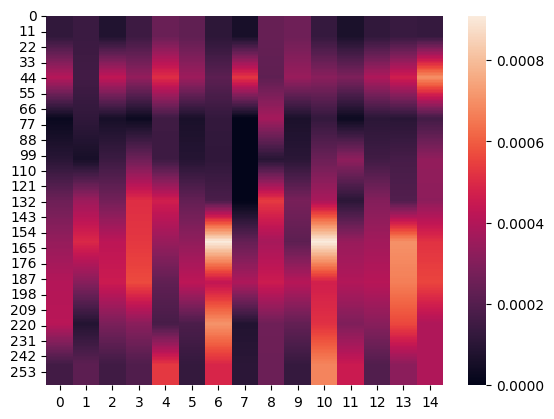

In [125]:
dd = pd.read_pickle("/home/hb/python/phospho/data/required/0308_final_train_test/dataset3.pkl")
pairs = dd['kin_id'] + '_' + dd['subseq']
total_pair_mapping = {pair: total_pair for pair, total_pair in zip(dd['pair'], pairs)}
total_pair_mapping

kinmap = pd.read_csv("../kinase_family_kinmap.csv")
df = pd.read_pickle("grad_cam_result.pkl")
del df['grad_cam'], df['grad_cam_pp']
df.head(5)

{'O00506_NLSAAQTLRAAFI': 'O00506_VNLSAAQTLRAAFIK',
 'O14733_NRSGAMSPMSWNS': 'O14733_QNRSGAMSPMSWNSD',
 'O14920_TGSGIKSHNSALY': 'O14920_ATGSGIKSHNSALYS',
 'O14920_HPLSLTSDQYKAY': 'O14920_SHPLSLTSDQYKAYL',
 'O14920_PPYADPSLQAPVR': 'O14920_TPPYADPSLQAPVRV',
 'O14920_HSPLSLSAQSVME': 'O14920_GHSPLSLSAQSVMEE',
 'O14920_GIKSHNSALYSQV': 'O14920_SGIKSHNSALYSQVQ',
 'O14920_SIRLQISNPDLKD': 'O14920_DSIRLQISNPDLKDR',
 'O14920_LDDRHDSGLDSMK': 'O14920_LLDDRHDSGLDSMKD',
 'O14920_YKCEGRSAGSIPG': 'O14920_RYKCEGRSAGSIPGE',
 'O14920_TYETFKSIMKKSP': 'O14920_RTYETFKSIMKKSPF',
 'O14920_SNSHPLSLTSDQY': 'O14920_ISNSHPLSLTSDQYK',
 'O14920_SPFYRDSLPGSQR': 'O14920_DSPFYRDSLPGSQRK',
 'O14920_DLEQAISQRIQTN': 'O14920_RDLEQAISQRIQTNN',
 'O14920_EMSSSHSAQSMVS': 'O14920_GEMSSSHSAQSMVSG',
 'O14920_FHSLPFSLTKMPN': 'O14920_RFHSLPFSLTKMPNT',
 'O14920_DIFSSVSVPPSLK': 'O14920_PDIFSSVSVPPSLKV',
 'O14920_KELDQGSLCTSFV': 'O14920_AKELDQGSLCTSFVG',
 'O14920_LSLSAQSVMEELN': 'O14920_PLSLSAQSVMEELNT',
 'O14920_AFGGYLSEVVEEN': 'O1492

In [129]:
kinmap = pd.read_csv("../kinase_family_kinmap.csv")
df = pd.read_pickle("grad_cam_result.pkl")
del df['grad_cam'], df['grad_cam_pp']
df.head(5)

,pair,kinase,uniprotID,substrate,family,group,gradcam_resize,gradcam_pp_resize,flatten_gradcam
0,Q9UM73_RVCSLCYRELAAQ,ALK,Q9UM73,RVCSLCYRELAAQ,ALK,TK,"[[0.0, 0.0, 0.0, 0.0, 0.000373999, 0.0, 0.0, 0...","[[0.0205638, 0.05325572, 0.06773758, 0.1056384...","[0.0, 0.0, 0.0, 0.0, 0.000373999, 0.0, 0.0, 0...."
1,Q9UM73_GLARDIYKDPDYV,ALK,Q9UM73,GLARDIYKDPDYV,ALK,TK,"[[0.0, 0.00014063294, 0.0, 0.00013235305, 0.0,...","[[0.033400796, 0.0, 0.09327865, 0.0, 0.0822797...","[0.0, 0.00014063294, 0.0, 0.00013235305, 0.0, ..."
2,Q9UM73_YRPSYSYDYEFDL,ALK,Q9UM73,YRPSYSYDYEFDL,ALK,TK,"[[0.0, 0.0, 0.0, 0.0, 3.9635444e-05, 0.0, 3.96...","[[0.0, 0.0, 0.0, 0.0, 0.11245741, 0.0, 0.11245...","[0.0, 0.0, 0.0, 0.0, 3.9635444e-05, 0.0, 3.963..."
3,P29376_RRAPELYRAPFPL,LTK,P29376,RRAPELYRAPFPL,ALK,TK,"[[0.0, 0.0, 0.0, 7.2841503e-06, 0.0001283738, ...","[[0.0625958, 0.0625958, 0.0625958, 0.0, 0.0, 0...","[0.0, 0.0, 0.0, 7.2841503e-06, 0.0001283738, 0..."
4,Q9UM73_KQVEELYHSLLEL,ALK,Q9UM73,KQVEELYHSLLEL,ALK,TK,"[[0.0, 0.0, 0.0, 0.0, 0.00044131308, 0.0004413...","[[0.0, 0.109487526, 0.0, 0.114758596, 0.116214...","[0.0, 0.0, 0.0, 0.0, 0.00044131308, 0.00044131..."


In [130]:
df_total_pair = df['pair'].apply(lambda x: total_pair_mapping[x])
df.insert(0, 'total_pair', df_total_pair)
df['substrate15'] = df['total_pair'].apply(lambda x: x.split('_')[1])
df

,total_pair,pair,kinase,uniprotID,substrate,family,group,gradcam_resize,gradcam_pp_resize,flatten_gradcam,substrate15
0,Q9UM73_LRVCSLCYRELAAQK,Q9UM73_RVCSLCYRELAAQ,ALK,Q9UM73,RVCSLCYRELAAQ,ALK,TK,"[[0.0, 0.0, 0.0, 0.0, 0.000373999, 0.0, 0.0, 0...","[[0.0205638, 0.05325572, 0.06773758, 0.1056384...","[0.0, 0.0, 0.0, 0.0, 0.000373999, 0.0, 0.0, 0....",LRVCSLCYRELAAQK
1,Q9UM73_FGLARDIYKDPDYVR,Q9UM73_GLARDIYKDPDYV,ALK,Q9UM73,GLARDIYKDPDYV,ALK,TK,"[[0.0, 0.00014063294, 0.0, 0.00013235305, 0.0,...","[[0.033400796, 0.0, 0.09327865, 0.0, 0.0822797...","[0.0, 0.00014063294, 0.0, 0.00013235305, 0.0, ...",FGLARDIYKDPDYVR
2,Q9UM73_PYRPSYSYDYEFDLG,Q9UM73_YRPSYSYDYEFDL,ALK,Q9UM73,YRPSYSYDYEFDL,ALK,TK,"[[0.0, 0.0, 0.0, 0.0, 3.9635444e-05, 0.0, 3.96...","[[0.0, 0.0, 0.0, 0.0, 0.11245741, 0.0, 0.11245...","[0.0, 0.0, 0.0, 0.0, 3.9635444e-05, 0.0, 3.963...",PYRPSYSYDYEFDLG
3,P29376_RRRAPELYRAPFPLY,P29376_RRAPELYRAPFPL,LTK,P29376,RRAPELYRAPFPL,ALK,TK,"[[0.0, 0.0, 0.0, 7.2841503e-06, 0.0001283738, ...","[[0.0625958, 0.0625958, 0.0625958, 0.0, 0.0, 0...","[0.0, 0.0, 0.0, 7.2841503e-06, 0.0001283738, 0...",RRRAPELYRAPFPLY
4,Q9UM73_MKQVEELYHSLLELG,Q9UM73_KQVEELYHSLLEL,ALK,Q9UM73,KQVEELYHSLLEL,ALK,TK,"[[0.0, 0.0, 0.0, 0.0, 0.00044131308, 0.0004413...","[[0.0, 0.109487526, 0.0, 0.114758596, 0.116214...","[0.0, 0.0, 0.0, 0.0, 0.00044131308, 0.00044131...",MKQVEELYHSLLELG
...,...,...,...,...,...,...,...,...,...,...,...
21150,Q9BYP7_KRASFAKSVIGTPEF,Q9BYP7_RASFAKSVIGTPE,Wnk3,Q9BYP7,RASFAKSVIGTPE,WNK,Other,"[[0.0, 0.0, 1.0144075e-05, 0.0, 0.0, 1.0144075...","[[0.0, 0.16088328, 0.0, 0.0, 0.0, 0.0, 0.0, 0....","[0.0, 0.0, 1.0144075e-05, 0.0, 0.0, 1.0144075e...",KRASFAKSVIGTPEF
21151,Q9BYP7_IEDLSQNSITGEHSQ,Q9BYP7_EDLSQNSITGEHS,Wnk3,Q9BYP7,EDLSQNSITGEHS,WNK,Other,"[[0.00023869786, 0.0023622129, 0.00017016295, ...","[[0.0, 0.3588531, 0.38790095, 0.0, 0.0, 0.0731...","[0.00023869786, 0.0023622129, 0.00017016295, 0...",IEDLSQNSITGEHSQ
21152,Q9H4A3_VRRVPGSSGRLHKTE,Q9H4A3_RRVPGSSGRLHKT,Wnk1,Q9H4A3,RRVPGSSGRLHKT,WNK,Other,"[[0.0005799708, 0.0, 0.0, 0.0005799708, 0.0005...","[[0.0, 0.0195809, 0.0195809, 0.0, 0.0, 0.0, 0....","[0.0005799708, 0.0, 0.0, 0.0005799708, 0.00056...",VRRVPGSSGRLHKTE
21153,Q9BYP7_FRGDRCRSLTGKPKL,Q9BYP7_RGDRCRSLTGKPK,Wnk3,Q9BYP7,RGDRCRSLTGKPK,WNK,Other,"[[6.855685e-05, 6.715357e-05, 0.00032500437, 0...","[[0.022324264, 0.085167415, 0.0, 0.08731468, 0...","[6.855685e-05, 6.715357e-05, 0.00032500437, 0....",FRGDRCRSLTGKPKL


In [106]:
df = pd.read_pickle("/home/hb/python/efficientnet_kincnn/gradcam/clustering_base_output.pkl")


,gradcam_resize,gradcam_pp_resize,flatten_gradcam,avg_gradcam_mm_bavg,avg_gradcam_sd_bavg,avg_gradcam_mm_aavg,avg_gradcam_sd_aavg,counts,family
kinase,,,,,,,,,
AMPKa1,"[[3.9470586e-05, 6.870308e-05, 6.5727654e-05, ...","[[0.031077811, 0.04074584, 0.051237017, 0.0312...","[3.9470586e-05, 6.870308e-05, 6.5727654e-05, 7...","[0.0049075964, 0.0030818258, 0.0055991025, 0.0...","[-0.3741798, -0.29832774, -0.3370822, -0.31743...","[0.02919781504766132, 0.034333510436278025, 0....","[-1.1009660667266747, -0.9128469400305113, -0....",171,CAMKL
AMPKa2,"[[9.270123e-05, 0.0001083347, 6.260049e-05, 0....","[[0.045693498, 0.05226395, 0.038299832, 0.0471...","[9.270123e-05, 0.0001083347, 6.260049e-05, 0.0...","[0.011526058, 0.004859587, 0.0053327098, 0.021...","[-0.28572878, -0.24245127, -0.34177506, -0.223...","[0.0749763311107154, 0.05575351180568459, 0.04...","[-0.9188916671104881, -0.8072595062785407, -0....",48,CAMKL
BARK1,"[[0.00089733565, 0.00074444554, 0.00085190847,...","[[0.17956038, 0.1383767, 0.12971027, 0.1433443...","[0.00089733565, 0.00074444554, 0.00085190847, ...","[0.111570746, 0.03339372, 0.072571, 0.14687517...","[1.0513076, 0.6544005, 0.84268045, 1.093789, 1...","[0.7669643810211336, 0.3995571081224893, 0.621...","[1.8333449618679507, 0.8874807891930447, 1.191...",74,GRK
BARK2,"[[0.0010258888, 0.00070233893, 0.0007155289, 0...","[[0.15472037, 0.09844321, 0.078313805, 0.08952...","[0.0010258888, 0.00070233893, 0.0007155289, 0....","[0.12755445, 0.03150493, 0.060953334, 0.110960...","[1.2649202, 0.5950345, 0.638026, 0.71759844, 0...","[0.8775205168853216, 0.3767994344159151, 0.521...","[2.273058692073444, 0.775299453468488, 0.81538...",21,GRK
BRK,"[[0.0003852183, 0.00019285154, 0.00062074425, ...","[[0.031337272, 0.042550627, 0.07232094, 0.0546...","[0.0003852183, 0.00019285154, 0.00062074425, 0...","[0.047896326, 0.008650772, 0.052878957, 0.0537...","[0.20033783, -0.12329109, 0.4957896, 0.1186174...","[0.3265419030745493, 0.10143296208434581, 0.45...","[0.08165737681939768, -0.5820879086234002, 0.5...",19,Src
CDC2,"[[0.00015620425, 0.00017972924, 0.00018171086,...","[[0.037469957, 0.048159573, 0.046053573, 0.039...","[0.00015620425, 0.00017972924, 0.00018171086, ...","[0.019421734, 0.008062141, 0.015479289, 0.0273...","[-0.18020704, -0.14179242, -0.16303496, -0.158...","[0.129589118045278, 0.09434065095090774, 0.130...","[-0.7016808169645116, -0.6170486408397773, -0....",606,CDK
CDK2,"[[0.000106966305, 0.00012689158, 0.00012680091...","[[0.034940198, 0.02614333, 0.035877194, 0.0313...","[0.000106966305, 0.00012689158, 0.00012680091,...","[0.013299709, 0.0056919977, 0.010801708, 0.020...","[-0.26202425, -0.21628815, -0.24543424, -0.227...","[0.08724433922110993, 0.06578308726969127, 0.0...","[-0.8700982503883302, -0.7578198672886607, -0....",381,CDK
CDK3,"[[0.0004831565, 0.00035842764, 0.0005832623, 0...","[[0.06823537, 0.08249732, 0.08515879, 0.079548...","[0.0004831565, 0.00035842764, 0.0005832623, 0....","[0.060073532, 0.016078047, 0.04968601, 0.06369...","[0.36307883, 0.11015447, 0.4395432, 0.22253776...","[0.4107690553884651, 0.19092311914037602, 0.42...","[0.4166531239033462, -0.14095646952355226, 0.4...",16,CDK
CDK4,"[[0.00012744016, 0.0001977583, 0.00014277025, ...","[[0.03886055, 0.046708923, 0.042369865, 0.0352...","[0.00012744016, 0.0001977583, 0.00014277025, 0...","[0.015845343, 0.008870875, 0.012162082, 0.0310...","[-0.22800426, -0.116373025, -0.2214703, -0.119...","[0.10485191564472385, 0.10408495562483447, 0.1...","[-0.8000678260379663, -0.5690152114074728, -0....",78,CDK


In [108]:
df[df['family']=='STE20'].index

Index(['MST1', 'MST2', 'MST4', 'OSR1', 'PAK1', 'PAK2', 'PAK4', 'PAK5',
       'STLK3'],
      dtype='object', name='kinase')

In [113]:
gc = pd.read_pickle("/home/hb/python/efficientnet_kincnn/gradcam/clustering_base_output.pkl")
gc

,gradcam_resize,gradcam_pp_resize,flatten_gradcam,avg_gradcam_mm_bavg,avg_gradcam_sd_bavg,avg_gradcam_mm_aavg,avg_gradcam_sd_aavg,counts,family
kinase,,,,,,,,,
AMPKa1,"[[3.9470586e-05, 6.870308e-05, 6.5727654e-05, ...","[[0.031077811, 0.04074584, 0.051237017, 0.0312...","[3.9470586e-05, 6.870308e-05, 6.5727654e-05, 7...","[0.0049075964, 0.0030818258, 0.0055991025, 0.0...","[-0.3741798, -0.29832774, -0.3370822, -0.31743...","[0.02919781504766132, 0.034333510436278025, 0....","[-1.1009660667266747, -0.9128469400305113, -0....",171,CAMKL
AMPKa2,"[[9.270123e-05, 0.0001083347, 6.260049e-05, 0....","[[0.045693498, 0.05226395, 0.038299832, 0.0471...","[9.270123e-05, 0.0001083347, 6.260049e-05, 0.0...","[0.011526058, 0.004859587, 0.0053327098, 0.021...","[-0.28572878, -0.24245127, -0.34177506, -0.223...","[0.0749763311107154, 0.05575351180568459, 0.04...","[-0.9188916671104881, -0.8072595062785407, -0....",48,CAMKL
BARK1,"[[0.00089733565, 0.00074444554, 0.00085190847,...","[[0.17956038, 0.1383767, 0.12971027, 0.1433443...","[0.00089733565, 0.00074444554, 0.00085190847, ...","[0.111570746, 0.03339372, 0.072571, 0.14687517...","[1.0513076, 0.6544005, 0.84268045, 1.093789, 1...","[0.7669643810211336, 0.3995571081224893, 0.621...","[1.8333449618679507, 0.8874807891930447, 1.191...",74,GRK
BARK2,"[[0.0010258888, 0.00070233893, 0.0007155289, 0...","[[0.15472037, 0.09844321, 0.078313805, 0.08952...","[0.0010258888, 0.00070233893, 0.0007155289, 0....","[0.12755445, 0.03150493, 0.060953334, 0.110960...","[1.2649202, 0.5950345, 0.638026, 0.71759844, 0...","[0.8775205168853216, 0.3767994344159151, 0.521...","[2.273058692073444, 0.775299453468488, 0.81538...",21,GRK
BRK,"[[0.0003852183, 0.00019285154, 0.00062074425, ...","[[0.031337272, 0.042550627, 0.07232094, 0.0546...","[0.0003852183, 0.00019285154, 0.00062074425, 0...","[0.047896326, 0.008650772, 0.052878957, 0.0537...","[0.20033783, -0.12329109, 0.4957896, 0.1186174...","[0.3265419030745493, 0.10143296208434581, 0.45...","[0.08165737681939768, -0.5820879086234002, 0.5...",19,Src
CDC2,"[[0.00015620425, 0.00017972924, 0.00018171086,...","[[0.037469957, 0.048159573, 0.046053573, 0.039...","[0.00015620425, 0.00017972924, 0.00018171086, ...","[0.019421734, 0.008062141, 0.015479289, 0.0273...","[-0.18020704, -0.14179242, -0.16303496, -0.158...","[0.129589118045278, 0.09434065095090774, 0.130...","[-0.7016808169645116, -0.6170486408397773, -0....",606,CDK
CDK2,"[[0.000106966305, 0.00012689158, 0.00012680091...","[[0.034940198, 0.02614333, 0.035877194, 0.0313...","[0.000106966305, 0.00012689158, 0.00012680091,...","[0.013299709, 0.0056919977, 0.010801708, 0.020...","[-0.26202425, -0.21628815, -0.24543424, -0.227...","[0.08724433922110993, 0.06578308726969127, 0.0...","[-0.8700982503883302, -0.7578198672886607, -0....",381,CDK
CDK3,"[[0.0004831565, 0.00035842764, 0.0005832623, 0...","[[0.06823537, 0.08249732, 0.08515879, 0.079548...","[0.0004831565, 0.00035842764, 0.0005832623, 0....","[0.060073532, 0.016078047, 0.04968601, 0.06369...","[0.36307883, 0.11015447, 0.4395432, 0.22253776...","[0.4107690553884651, 0.19092311914037602, 0.42...","[0.4166531239033462, -0.14095646952355226, 0.4...",16,CDK
CDK4,"[[0.00012744016, 0.0001977583, 0.00014277025, ...","[[0.03886055, 0.046708923, 0.042369865, 0.0352...","[0.00012744016, 0.0001977583, 0.00014277025, 0...","[0.015845343, 0.008870875, 0.012162082, 0.0310...","[-0.22800426, -0.116373025, -0.2214703, -0.119...","[0.10485191564472385, 0.10408495562483447, 0.1...","[-0.8000678260379663, -0.5690152114074728, -0....",78,CDK


In [17]:
gc = pd.read_pickle("/home/hb/python/efficientnet_kincnn/gradcam/clustering_base_output.pkl")
gc_mapk = df[df['family']=='MAPK']
gc_mapk.head(2)

,gradcam_resize,gradcam_pp_resize,flatten_gradcam,avg_gradcam_mm_bavg,avg_gradcam_sd_bavg,avg_gradcam_mm_aavg,avg_gradcam_sd_aavg,counts,family
kinase,,,,,,,,,
Erk1,"[[8.952749e-06, 1.0842219e-05, 9.939324e-06, 1...","[[0.001753404, 0.0018301116, 0.0017623418, 0.0...","[8.952749e-06, 1.0842219e-05, 9.939324e-06, 1....","[0.0011131457, 0.00048635143, 0.0008466953, 0....","[-0.42489138, -0.37990564, -0.42079964, -0.427...","[0.002952382706188322, 0.0030610186055637376, ...","[-1.2053517425240075, -1.067001092613839, -1.1...",417,MAPK
Erk2,"[[1.0869923e-05, 1.0000637e-05, 1.0615536e-05,...","[[0.0020606623, 0.0017638727, 0.001948145, 0.0...","[1.0869923e-05, 1.0000637e-05, 1.0615536e-05, ...","[0.0013515183, 0.0004486004, 0.000904299, 0.00...","[-0.42170587, -0.3810922, -0.41978505, -0.4263...","[0.004601158107278582, 0.0026061625654181892, ...","[-1.1987940858528747, -1.069243253161697, -1.1...",477,MAPK


In [31]:
kinase_subseq_dict = {}
for kinase in set(gc_mapk.index):
    _df = df[df['answer']==1]
    df_kinase = _df[_df['Name']==kinase] 
    kinase_subseq_dict[kinase] = df_kinase.subseq.tolist()
kinase_subseq_dict

{'p38d': ['VEVVSPATPVPSETA',
  'RVKEEPPSPPQSPRV',
  'SVPEFPLSPPKKKDL',
  'QAFELILSPRSKESV',
  'PVVSGDTSPRHLSNV',
  'SRTPSLPTPPTREPK',
  'RSRLTPVSPESSSTE',
  'EPPSPPQSPRVEEAS',
  'RRRLSNVSLTGLGTV',
  'GREKRSNSQSYIGRP',
  'GEKSFRRSVVGTPAY',
  'RTISPSTSNNIPLMR',
  'EDSNRTISPSTSNNI',
  'GVRRRRLSNVSLTGL',
  'GGKRSRLTPVSPESS',
  'QGPSQTSTPTDVTAI',
  'GAEIVYKSPVVSGDT',
  'SSVDTLLSPTALIDS',
  'TPGSRSRTPSLPTPP'],
 'JNK1': ['KKEKKQQSIAGSADS',
  'LTQSAPASPTNKGVH',
  'VKVNGDASPAAAESG',
  'TDGSLPSTPPPAEEE',
  'SGSLLTRSPTPAPFS',
  'GSCCTIMSPGEMEKH',
  'VETTMVPSPEAKLTE',
  'AALKSWLSRSVTSFF',
  'TQTNEFLSPEVFQHI',
  'GGGDEPGSPAQGKRG',
  'HSSPSSPSSDGKQKT',
  'SRRSGLCSPSYVAVT',
  'SCDKSTQTPSPPCQA',
  'SGEQAEGSPGGPGDS',
  'AAREMLHSPLPCTGG',
  'NMGLNPSSPNDPVTN',
  'SGYSSPGSPGTPGSR',
  'AELVRTDSPNFLCSV',
  'RDPVARTSPLQTPAA',
  'LPATPPATPPAASPS',
  'LLPTPPLSPSRRSGL',
  'PEGATPTSPVGHFAK',
  'APPPGSCSPSLSPSS',
  'ILDLISESPIKGRAQ',
  'QPSFVPKSPDASSAF',
  'PCPQPLRSPSLDNPT',
  'SAYGGLTSPGLSYSL',
  'NFDFVTETPLEGDF

In [131]:
alk = df[df['kinase'] == 'ALK']
sequences = [x for x in alk.substrate15]

In [33]:
# import weblogo
# from Bio import SeqIO

# def create_seq_logo(sequence_file):
#     # 서열 파일을 읽어옵니다.
#     sequences = SeqIO.parse(sequence_file, "fasta")

#     # 웹로고 옵션 설정
#     options = weblogo.LogoOptions()
#     options.unit_name = "probability"
#     options.fineprint = ""
#     options.color_scheme = weblogo.colorscheme.nucleotide

#     # 웹로고 데이터 생성
#     data = weblogo.LogoData.from_seqs(sequences)
#     data.composition()

#     # 시퀀스 로고 생성
#     seq_logo = weblogo.LogoFormat(data, options)

#     # 시퀀스 로고 이미지 저장
#     output_file = "seq_logo.png"
#     with open(output_file, "w") as f:
#         seq_logo.print_png(f, resolution=300)

#     print(f"시퀀스 로고가 생성되었습니다. 파일명: {output_file}")


# # 아래는 테스트용으로 예시 서열 파일을 사용합니다.
# sequence_file = "example.fasta"

# # 시퀀스 로고 생성 함수 호출
# create_seq_logo(sequence_file)
# data = weblogo.seq.SeqList(sequences)

In [32]:
import numpy as np
import pandas as pd
import seqlogo

In [37]:
t = ''.join([x for x in df['subseq'].unique()])
yes = []
for chr in t:
    if chr not in yes:
        yes.append(chr)
yes.sort()
yes.remove('_')
yes_ = "".join(yes)

In [76]:
'_' in kinase_subseq_dict['Erk1'][0]

True

In [71]:
kinase_subseq_dict = {x[0]: x[1] for x in sorted(kinase_subseq_dict.items())}
for sequences in kinase_subseq_dict.values():
    for x in sequences:
        if '_' in x:
            print(x)
            sequences.remove(x)

{'Erk1': ['PSSDSLSSPTLLAL_',
  'PTMPPPETPSEGRQP',
  'GGLPEVATPESEEAF',
  'KNENTEGSPQEDGVE',
  'ELSPTTLSPVNHSLD',
  'NAPAFGQSPGFGQGG',
  'DIPMFDDSPPPPPPP',
  'EKSPSVCSPLNMTSS',
  'TRVFKKSSPNCKLTV',
  'IGNVSASSPVQQGLG',
  'VPPPKPATPDFRSVL',
  'NYGTNPGTPPASTSP',
  'DGSCSSSSPPLPVLG',
  'GKIKRLRSQVQVSLE',
  'PAARTPQSPAPCVLL',
  'GNSSPPGSPTLQKFG',
  'GTPPASTSPFSQLAA',
  'FSGIESSSPEVKGYW',
  'FLTEYVATRWYRAPE',
  'EEEDGTGSPQLNNR_',
  'GAEIVYKSPVVSGDT',
  'EKNYALPSPATTEGG',
  'RRSSYEDSSLPSINA',
  'GTPGTPRSPPLGLIS',
  'RRDYDDMSPRRGPPP',
  'SPSVHPATPISPGRA',
  'SATDSDGSPLSNSQP',
  'IKSITPETPTEIPCG',
  'KNHIPVFSPALTDGS',
  'DGKTKIATPRGAAPP',
  'SALSYLQSPITTSPS',
  'SVPEFPLSPPKKKDL',
  'GQLVGLNSPNSILKA',
  'KVAAETQSPSLFGST',
  'QSPKRPRSPGSNSKV',
  'SASFPHTTPSMCLNP',
  'DSAIDTWSPSEWQMA',
  'QNERDRISTRRSSYE',
  'FFWDPSTSRRFSPPS',
  'VGEDAMKTPSPAAED',
  'NQSMDTGSPAELSPT',
  'EGFYFGETPLALAAC',
  'PPVQRLMTPKPVSIA',
  'SEGSGTATPSALITT',
  'PGKMSDVSPVVAAQQ',
  'TGSPAELSPTTLSPV',
  'ETPPRPRTPGRPLSS',
  'RI

In [86]:
for sequences in kinase_subseq_dict.values():
    for x in sequences:
        if '_' in x:
            print(x)
            sequences.remove(x)

PKRLGAHTP______


In [104]:
import matplotlib.pyplot as plt

np.random.seed(1234)

for _kinase, sequences in kinase_subseq_dict.items():
    freq = pd.DataFrame(np.zeros(shape=(15, 20)), columns=yes, index=range(0, 15))
    print(_kinase)
    for sub in sequences:
        sub = list(sub)
        for i, aa in enumerate(sub):
            if freq[aa][i] >=1:
                freq[aa][i] += 1
            else:
                freq[aa][i] = 1 

    for i in range(len(freq)):
        freq.iloc[i] = freq.iloc[i] / sum(freq.iloc[i])

    freq = seqlogo.Pfm(freq, alphabet_type='AA')
    seqlogo.seqlogo(freq, ic_scale=False, format='png', size='medium', title=_kinase, filename=f'/home/hb/python/efficientnet_kincnn/gradcam/output/seqlogo/{_kinase}.png')
    plt.show()

Erk1
Erk2
Erk5
Erk7
JNK1
JNK2
JNK3
NLK
p38a
p38b
p38d
p38g


In [110]:
kinase_subseq_dict.keys()

dict_keys(['Erk1', 'Erk2', 'Erk5', 'Erk7', 'JNK1', 'JNK2', 'JNK3', 'NLK', 'p38a', 'p38b', 'p38d', 'p38g'])

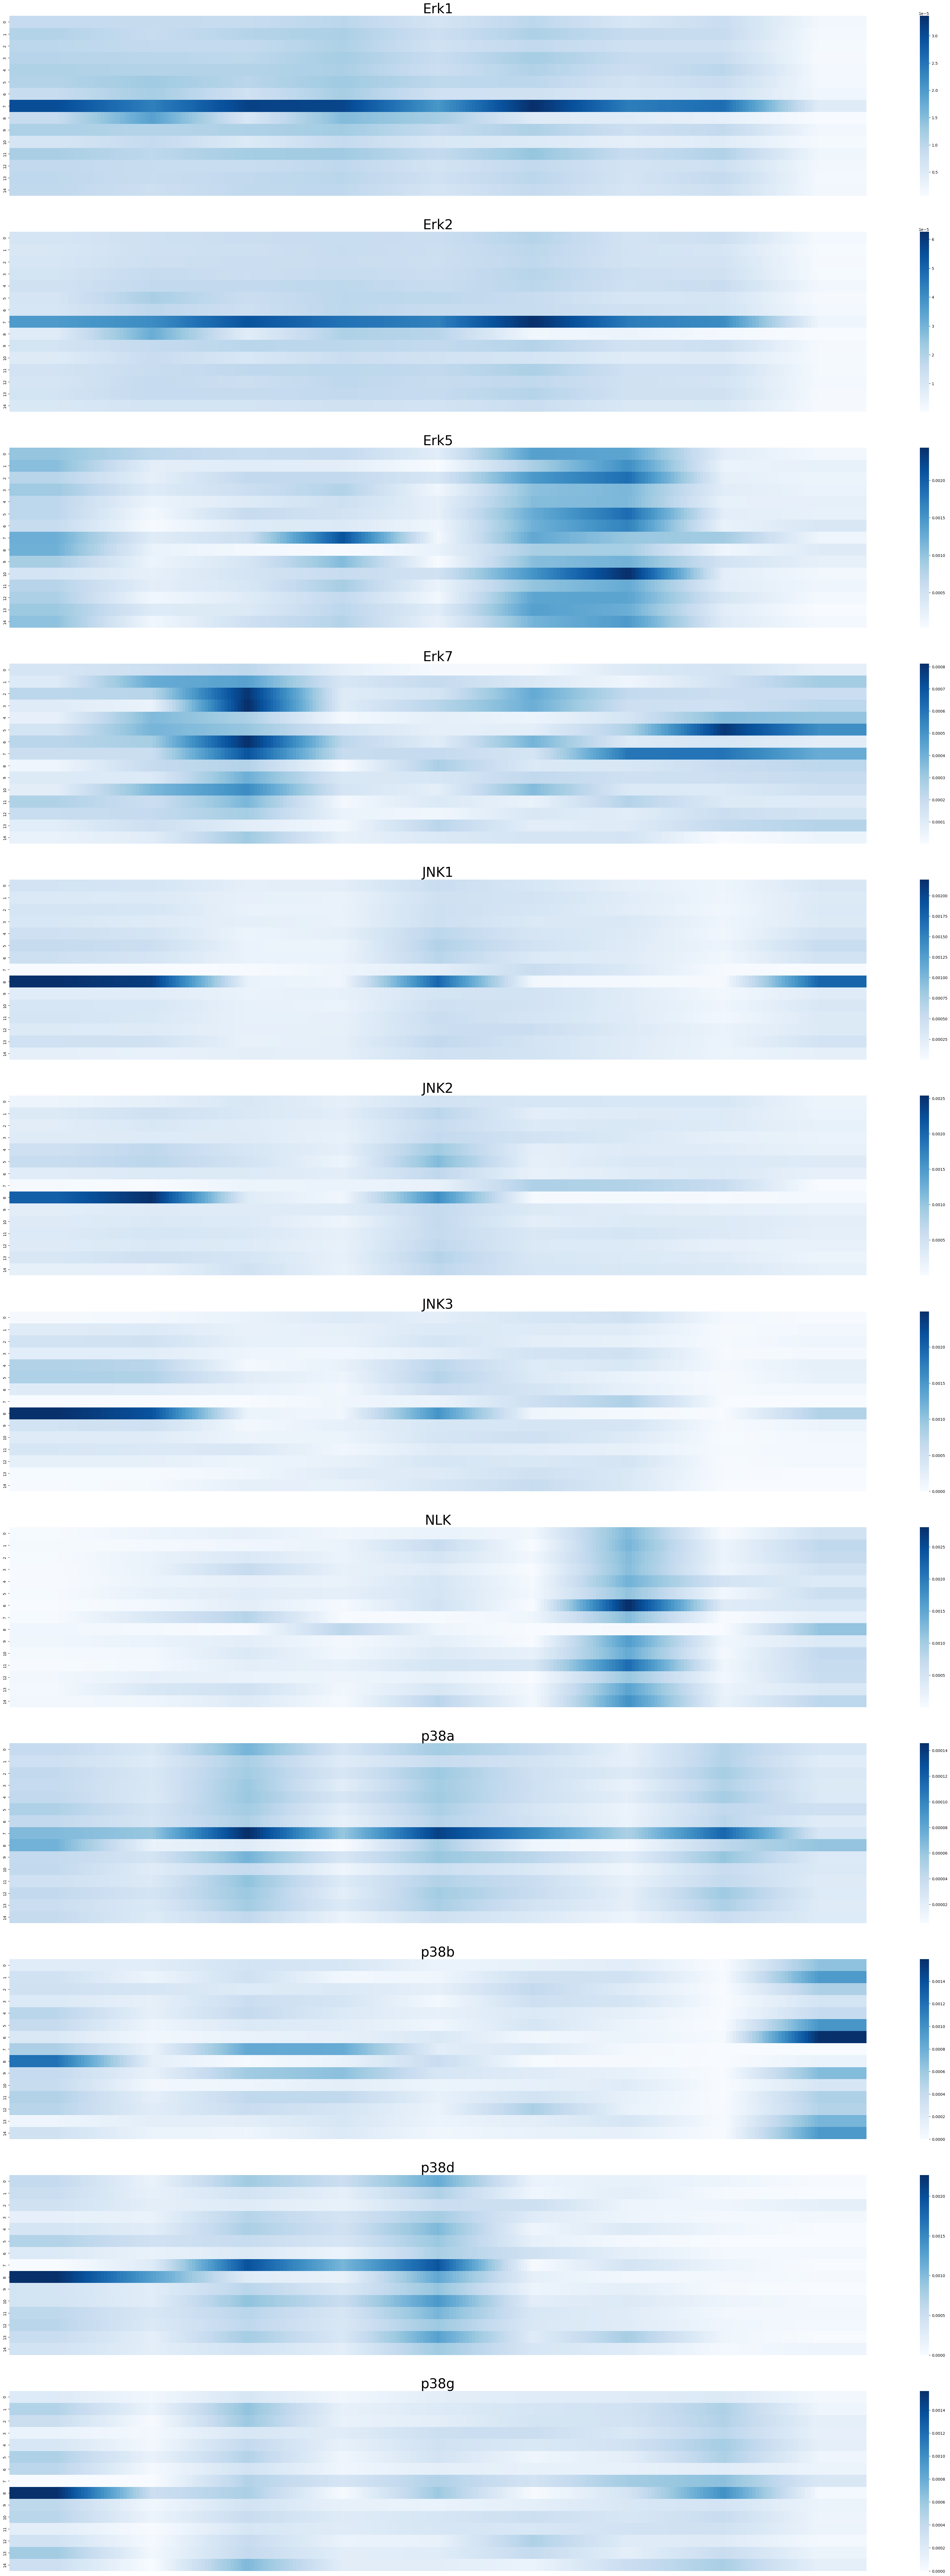

In [161]:
fig, ax = plt.subplots(len(kinase_subseq_dict.keys()), 1, figsize=(50, 10*len(kinase_subseq_dict.keys())),
                        sharex=True, sharey=True)
for idx, _kinase in enumerate(kinase_subseq_dict.keys()):

    gc_matrix = gc['gradcam_resize'][_kinase].T
    sns.heatmap(gc_matrix, cmap='Blues', ax=ax[idx])
    if idx != len(kinase_subseq_dict.keys()):
        ax[idx].set_xticks([])
    ax[idx].set_title(_kinase, fontsize=35)

In [129]:
tt = gc['gradcam_resize']['Erk1']

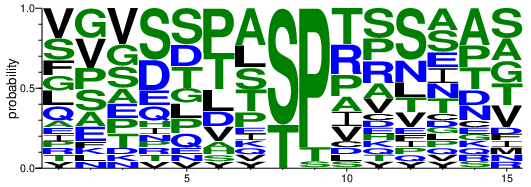

In [103]:
seqlogo.seqlogo(freq, ic_scale=False, format='png', size='medium', title=_kinase, filename=f'/home/hb/python/efficientnet_kincnn/gradcam/output/seqlogo/{_kinase}.png')

In [40]:
sequences = kinase_subseq_dict['p38d']

In [46]:
freq = pd.DataFrame(np.zeros(shape=(15, 20)), columns=yes, index=range(0, 15))

for sub in sequences:
    sub = list(sub)
    for i, aa in enumerate(sub):
        if freq[aa][i] >=1:
            freq[aa][i] += 1
        else:
            freq[aa][i] = 1 

for i in range(len(freq)):
    freq.iloc[i] = freq.iloc[i] / sum(freq.iloc[i])

In [51]:
freq = seqlogo.Pfm(freq, alphabet_type='AA')

AttributeError: 'Pfm' object has no attribute 'idxmax'

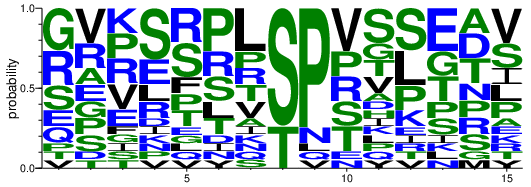

In [48]:
# ppm = seqlogo.Ppm(freq)
seqlogo.seqlogo(freq, ic_scale = False, format = 'png', size = 'medium')